## A simple example

In [1]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [2]:
x = pt.scalar(name="x")
y = pt.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: TensorType(float64, ())
x name = x
---
y type: TensorType(float64, (?,))
y name = y



In [3]:
z = x + y
z.name = "x + y"

In [4]:
w = pt.log(z)
w.name = "log(x + y)"

In [5]:
pytensor.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


In [6]:
f = pytensor.function(inputs=[x, y], outputs=w)

In [7]:
f(x=0, y=[1, np.e])

array([0., 1.])

In [8]:
# eval ：evaluate
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

In [9]:
w.eval({z: [1, np.e]})

array([0., 1.])

## Pytensor is clever

One of the most important features of pytensor is that it can automatically optimize the mathematical operations inside a graph. Let’s consider a simple example:

In [10]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

Elemwise{true_div,no_inplace} [id A] 'a / b'
 |a [id B]
 |b [id C]


In [11]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Elemwise{mul,no_inplace} [id A] 'b * c'
 |b [id B]
 |Elemwise{true_div,no_inplace} [id C] 'a / b'
   |a [id D]
   |b [id B]


In [12]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

DeepCopyOp [id A] 'a' 0
 |a [id B]


## What is in a Pytensor Graph?
The following diagram shows the basic structure of an pytensor graph.

In [13]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: TensorType(float64, (?,))
z name = x + y
z owner = Elemwise{add,no_inplace}(InplaceDimShuffle{x}.0, y)
z owner inputs = [InplaceDimShuffle{x}.0, y]
z owner op = Elemwise{add,no_inplace}
z owner output = [x + y]



In [15]:
# start from the top
#可以用波兰表达式来记忆：运算顺序排在后面，则结果也在后面
stack = [w]

pytensor.dprint(stack)

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")
while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]
---
Checking variable log(x + y) of type TensorType(float64, (?,))
 > Op is Elemwise{log,no_inplace}
 > Input 0 is x + y
---
Checking variable x + y of type TensorType(float64, (?,))
 > Op is Elemwise{add,no_inplace}
 > Input 0 is InplaceDimShuffle{x}.0
 > Input 1 is y
---
Checking variable InplaceDimShuffle{x}.0 of type TensorType(float64, (1,))
 > Op is InplaceDimShuffle{x}
 > Input 0 is x
---
Checking variable y of type TensorType(float64, (?,))
 > y is a root variable
---
Checking variable x of type TensorType(float64, ())
 > x is a root variable


## Graph manipulation 101
Another interesting feature of PyTensor is the ability to manipulate the computational graph, something that is not possible with TensorFlow or PyTorch. Here we continue with the example above in order to illustrate the main idea around this technique.

In [16]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs=[w]))

[x, y]

In [17]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

In [18]:
pytensor.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


In [19]:
new_w = pytensor.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Elemwise{log,no_inplace} [id A] 'log(exp(x + y))'
 |Elemwise{exp,no_inplace} [id B] 'exp(x + y)'
   |Elemwise{add,no_inplace} [id C] 'x + y'
     |InplaceDimShuffle{x} [id D]
     | |x [id E]
     |y [id F]


In [20]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

In [21]:
    f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Elemwise{add,no_inplace} [id A] 'x + y' 1
 |InplaceDimShuffle{x} [id B] 0
 | |x [id C]
 |y [id D]


## Pytensor RandomVariables

Now that we have seen pytensor’s basics we want to move in the direction of random variables.

How do we generate random numbers in numpy? To illustrate it we can sample from a normal distribution:

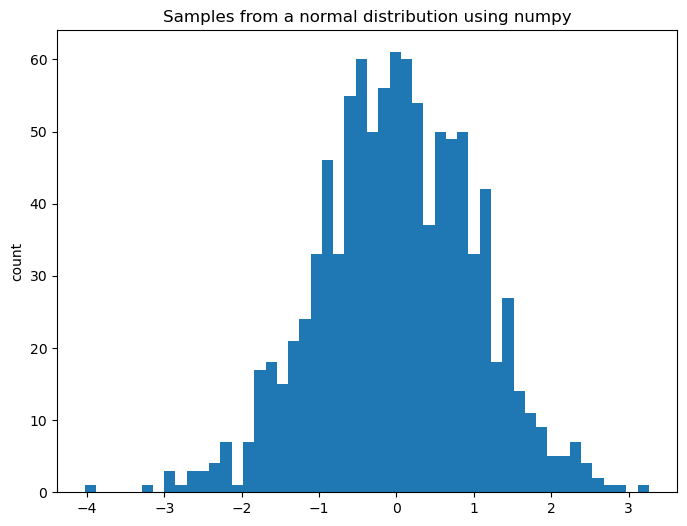

In [23]:
a = np.random.normal(loc=0, scale=1, size=1_000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a, color="C0", bins=50)
ax.set(title="Samples from a normal distribution using numpy", ylabel="count");

In [24]:
y = pt.random.normal(loc=0, scale=1, name="y")
y.type

TensorType(float64, ())

In [25]:
pytensor.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28B93F21700>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1} [id F]


### The inputs are always in the following order:

- rng shared variable

- size

- dtype (number code)

- arg1

- arg2

- argn

In [26]:
y.eval()

array(1.87458073)

In [27]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: 1.8745807305517819
Sample 1: 1.8745807305517819
Sample 2: 1.8745807305517819
Sample 3: 1.8745807305517819
Sample 4: 1.8745807305517819
Sample 5: 1.8745807305517819
Sample 6: 1.8745807305517819
Sample 7: 1.8745807305517819
Sample 8: 1.8745807305517819
Sample 9: 1.8745807305517819


In [28]:
x = pm.Normal.dist(mu=0, sigma=1)
pytensor.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28B93F22A40>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1.0} [id F]


In [29]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: 0.12699888716086746
Sample 1: 0.12699888716086746
Sample 2: 0.12699888716086746
Sample 3: 0.12699888716086746
Sample 4: 0.12699888716086746
Sample 5: 0.12699888716086746
Sample 6: 0.12699888716086746
Sample 7: 0.12699888716086746
Sample 8: 0.12699888716086746
Sample 9: 0.12699888716086746


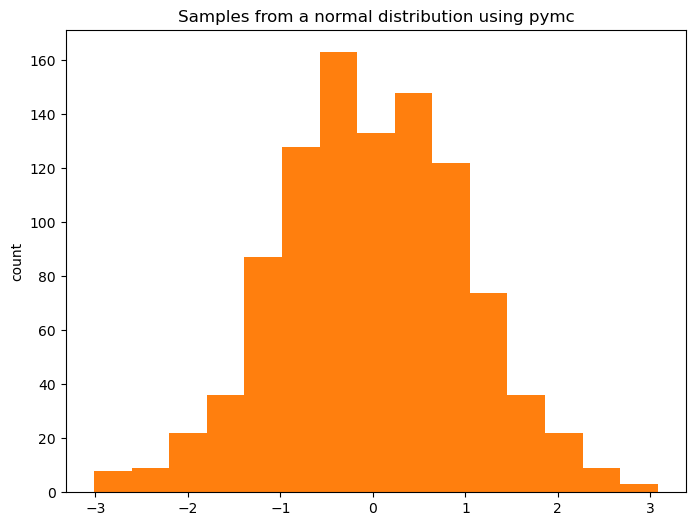

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(pm.draw(x, draws=1_000), color="C1", bins=15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count");

## What is going on behind the scenes?

In [31]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=np.array([0, 0]), sigma=np.array([1, 2]))

pytensor.dprint(z)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28B9475DB60>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1. 2.]} [id F]


In [32]:
model.basic_RVs

[z ~ N(<constant>, <constant>)]

In [33]:
pytensor.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28B9475DB60>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1. 2.]} [id F]


In [34]:
for i in range(10):
    print(f"Sample {i}: {z.eval()}")

Sample 0: [0.67058738 3.74041469]
Sample 1: [0.67058738 3.74041469]
Sample 2: [0.67058738 3.74041469]
Sample 3: [0.67058738 3.74041469]
Sample 4: [0.67058738 3.74041469]
Sample 5: [0.67058738 3.74041469]
Sample 6: [0.67058738 3.74041469]
Sample 7: [0.67058738 3.74041469]
Sample 8: [0.67058738 3.74041469]
Sample 9: [0.67058738 3.74041469]


In [35]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: [ 1.13265313 -0.50856722]
Sample 1: [1.38847891 5.08138345]
Sample 2: [-2.76056689  0.3025941 ]
Sample 3: [ 0.10745039 -0.47859154]
Sample 4: [-1.22658602  2.76929619]
Sample 5: [-0.90755592 -0.03915878]
Sample 6: [0.82406635 3.71064448]
Sample 7: [-0.56651402  2.27324814]
Sample 8: [-0.34736548  1.18099196]
Sample 9: [-1.02874587 -2.27858685]


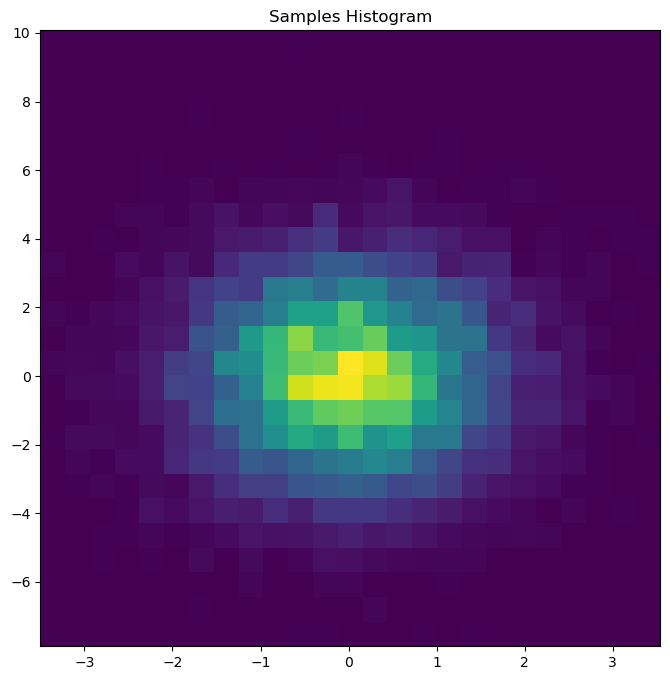

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
z_draws = pm.draw(vars=z, draws=10_000)
ax.hist2d(x=z_draws[:, 0], y=z_draws[:, 1], bins=25)
ax.set(title="Samples Histogram");

   ## Enough with Random Variables, I want to see some (log)probabilities!

In [37]:
model

z ~ N(<constant>, <constant>)

In [38]:
z_value = pt.vector(name="z")
z_logp = pm.logp(rv=z, value=z_value)

In [39]:
pytensor.dprint(z_logp)

## There is also a handy pymc function to compute the log cumulative probability of a random variable logcdf().

Check{sigma > 0} [id A] 'z_logprob'
 |Elemwise{sub,no_inplace} [id B]
 | |Elemwise{sub,no_inplace} [id C]
 | | |Elemwise{mul,no_inplace} [id D]
 | | | |InplaceDimShuffle{x} [id E]
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G]
 | | |   |Elemwise{true_div,no_inplace} [id H]
 | | |   | |Elemwise{sub,no_inplace} [id I]
 | | |   | | |z [id J]
 | | |   | | |TensorConstant{(2,) of 0} [id K]
 | | |   | |TensorConstant{[1. 2.]} [id L]
 | | |   |InplaceDimShuffle{x} [id M]
 | | |     |TensorConstant{2} [id N]
 | | |InplaceDimShuffle{x} [id O]
 | |   |Elemwise{log,no_inplace} [id P]
 | |     |Elemwise{sqrt,no_inplace} [id Q]
 | |       |TensorConstant{6.283185307179586} [id R]
 | |Elemwise{log,no_inplace} [id S]
 |   |TensorConstant{[1. 2.]} [id L]
 |All [id T]
   |MakeVector{dtype='bool'} [id U]
     |All [id V]
       |Elemwise{gt,no_inplace} [id W]
         |TensorConstant{[1. 2.]} [id L]
         |InplaceDimShuffle{x} [id X]
           |TensorConstant{0} [id Y]

In [40]:
z_logp.eval({z_value: [0, 0]})

array([-0.91893853, -1.61208571])

In [41]:
scipy.stats.norm.logpdf(x=np.array([0, 0]), loc=np.array([0, 0]), scale=np.array([1, 2]))

array([-0.91893853, -1.61208571])

In [42]:
pytensor.dprint(model.logp(sum=False))

Check{sigma > 0} [id A] 'z_logprob'
 |Elemwise{sub,no_inplace} [id B]
 | |Elemwise{sub,no_inplace} [id C]
 | | |Elemwise{mul,no_inplace} [id D]
 | | | |InplaceDimShuffle{x} [id E]
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G]
 | | |   |Elemwise{true_div,no_inplace} [id H]
 | | |   | |Elemwise{sub,no_inplace} [id I]
 | | |   | | |z [id J]
 | | |   | | |TensorConstant{(2,) of 0} [id K]
 | | |   | |TensorConstant{[1. 2.]} [id L]
 | | |   |InplaceDimShuffle{x} [id M]
 | | |     |TensorConstant{2} [id N]
 | | |InplaceDimShuffle{x} [id O]
 | |   |Elemwise{log,no_inplace} [id P]
 | |     |Elemwise{sqrt,no_inplace} [id Q]
 | |       |TensorConstant{6.283185307179586} [id R]
 | |Elemwise{log,no_inplace} [id S]
 |   |TensorConstant{[1. 2.]} [id L]
 |All [id T]
   |MakeVector{dtype='bool'} [id U]
     |All [id V]
       |Elemwise{gt,no_inplace} [id W]
         |TensorConstant{[1. 2.]} [id L]
         |InplaceDimShuffle{x} [id X]
           |TensorConstant{0} [id Y]

In [43]:
logp_function = model.compile_logp(sum=False)

In [44]:
point = model.initial_point()
point

{'z': array([0., 0.])}

In [45]:
logp_function(point)

[array([-0.91893853, -1.61208571])]

## What are value variables and Why are they important?

As he have seen above, a logp graph does not have random variables. Instead it’s defined in terms of input (value) variables. When we want to sample, each random variable (RV) is replaced by a logp function evaluated at the respective input (value) variable. Let’s see how this works through some examples. RV and value variables can be observed in these scipy operations:

In [46]:
rv = scipy.stats.norm(0, 1)

# Equivalent to rv = pm.Normal("rv", 0, 1)
scipy.stats.norm(0, 1)

In [47]:
# Equivalent to rv_draw = pm.draw(rv, 3)
rv.rvs(3)

array([2.25598305, 0.15670982, 1.82508404])

In [48]:
# Equivalent to rv_logp = pm.logp(rv, 1.25)
rv.logpdf(1.25)

-1.7001885332046727

In [49]:
with pm.Model() as model_2:
    mu = pm.Normal(name="mu", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=3)
    x = pm.Normal(name="x", mu=mu, sigma=sigma)

In [50]:
model_2.rvs_to_values

{mu ~ N(0, 2): mu, sigma ~ N**+(0, 3): sigma_log__, x ~ N(mu, sigma): x}

**Observe that for sigma the associated value is in the log scale as in practice we require unbounded values for NUTS sampling.**

In [51]:
model_2.value_vars

[mu, sigma_log__, x]

In [52]:
# extract values as pytensor.tensor.var.TensorVariable
mu_value = model_2.rvs_to_values[mu]
sigma_log_value = model_2.rvs_to_values[sigma]
x_value = model_2.rvs_to_values[x]
# element-wise log-probability of the model (we do not take te sum)
logp_graph = pt.stack(model_2.logp(sum=False))
# evaluate by passing concrete values
logp_graph.eval({mu_value: 0, sigma_log_value: -10, x_value: 0})

array([ -1.61208571, -11.32440364,   9.08106147])

In [53]:
print(
    f"""
mu_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=2)}
sigma_log_value -> {- 10 + scipy.stats.halfnorm.logpdf(x=np.exp(-10), loc=0, scale=3)} 
x_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=np.exp(-10))}
"""
)


mu_value -> -1.612085713764618
sigma_log_value -> -11.324403641427345 
x_value -> 9.081061466795328



In [54]:
model_2.compile_logp(sum=False)({"mu": 0, "sigma_log__": -10, "x": 0})

[array(-1.61208571), array(-11.32440364), array(9.08106147)]

In [55]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

ModuleNotFoundError: No module named 'watermark'